# Extreme Learning Machine Based Prognostics of Battery Life
**Reference:** R. Razavi-Far, S. Chakrabarti, M. Saif, E. Zio and V. Palade, "Extreme Learning Machine Based Prognostics of Battery Life," in International Journal on Artificial Intelligence Tools, Vol. 27, No. 08 (2018)

DOI: 10.1142/S0218213018500367

In [ ]:
!nvidia-smi

Tue Jan  3 14:58:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import dataset from Google Drive
Alternatively, upload the CALCE.npy file directly to the Colab instance.

In [ ]:
# import packages
import shutil
from google.colab import drive

# Mount drive
drive.mount('/content/drive', force_remount=True)

# Copy to location
dest = '/content/'                                      # this is in the colab VM
drive_src = '/content/drive/MyDrive/datasets/CALCE/'    # location from GDrive (folder)
src = drive_src + "CALCE.npy"                           # Specify file name
print(f"Copying {src} to {dest}")                       
shutil.copy(src,dest)                                   # Copy to dest
print("Done.")

Mounted at /content/drive
Copying /content/drive/MyDrive/datasets/CALCE/CALCE.npy to /content/
Done.


## Importing Packages

In [ ]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

import pandas as pd

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Setting up device-agnostic code

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Data Processing
Load the pre-processed data. Make sure that CALCE.npy is in the same directory as this notebook, or that it has been uploaded to the Colab instance (if using Google Colab).

In [ ]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

Plot the data to confirm dataset has been loaded successfully.

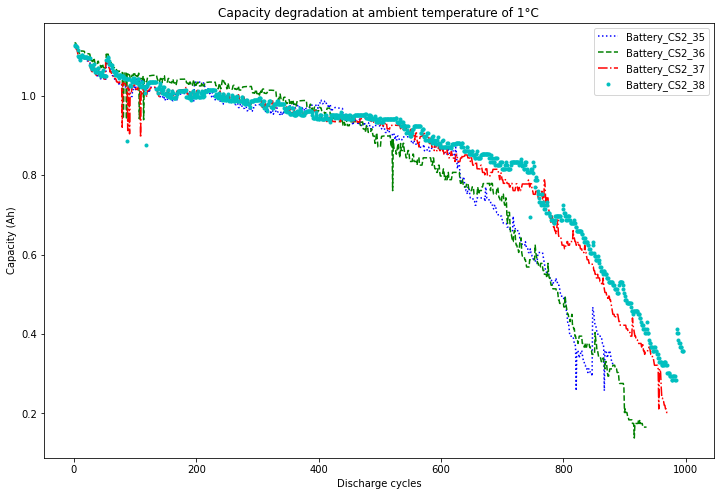

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

## Functions for building the data sequences

In [ ]:
def split_seq(sequence1, window_size=8, end=1):
  '''
  Splits an input sequence by a defined window size up to a defined portion of the sequence.
  Outputs array X with window_size steps and array y with the next step.

  Keyword arguments:
  ------------------
  sequence1 -- the  sequence to be split
  window_size -- sequence length of X (default: 8)
  end -- define what percent of the sequence to include (default: 1)
  '''
  # define empty variable
  X1, y1 = [], []


  for i in range(len(sequence1)):

    # compute end index
    end_i = i + window_size

    # check if end of the sequence is reached; break if end is reached
    if (end_i) > ( round(len(sequence1)*end) - 1):
      break

    seq1_x, seq1_y = sequence1[i:end_i], sequence1[end_i] 
    X1.append(seq1_x)
    y1.append(seq1_y)

  return np.array(X1), np.array(y1)

Declare function to split the data into training and testing sets.

In [ ]:
def split_train_test(Battery_list, 
                     Battery, 
                     leave_out,
                     window_size=16, 
                     end=1,
                     train_split=1,
                     test_split=0.4):
  
  Train_list = Battery_list.copy()

  for entry in leave_out:
    Train_list.pop(Train_list.index(entry))

  sequences = {}

  for item in Battery_list:
    df_result = Battery[item]
    Cycle, Capacity = df_result['cycle'], df_result['capacity']
    X_cap, y_cap = split_seq(Capacity, window_size, end)
    sequences[item] = X_cap, y_cap

  X_train, y_train = [], []
  X_test, y_test = [], []

  test_sequence = {}
  test_labels = {}

  for item in Train_list:
    # Access items from sequences dictionary
    X_cap, y_cap = sequences[item]

    # Get number of data points
    data_points = len(X_cap)
    data_points_test = len(Capacity)

    # Compute train-test split index
    train_split_idx = round(train_split * data_points)
    
    # Split the data to training and test set
    X_train.append(X_cap[:(train_split_idx)])
    y_train.append(y_cap[:(train_split_idx)])

  for item in leave_out:
    # For one step ahead
    X_cap, y_cap = sequences[item]
    data_points = len(X_cap)
    test_split_idx = round(test_split * data_points)

    X_test.append(X_cap[(test_split_idx):])
    y_test.append(y_cap[(test_split_idx):])

    # For Iterative multi step ahead
    df_result = Battery[item]
    Cycle, Capacity = df_result['cycle'], df_result['capacity']
    data_points_test = len(Capacity)
    test_split_idx = round(test_split * data_points_test)

    # Create dictionary for test
    test_sequence[item] = Capacity[:(test_split_idx)], Cycle[:(test_split_idx)]
    test_labels[item] = Capacity[(test_split_idx):], Cycle[(test_split_idx):]

  # Concatenate lists
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  X_test = np.concatenate(X_test, axis=0)
  y_test = np.concatenate(y_test, axis=0)

  # Reshape y
  y_train = y_train.reshape(-1,1)
  y_test = y_test.reshape(-1,1)

  # Convert to tensors
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
  X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

  return X_train, y_train, X_test, y_test, test_sequence, test_labels

Split the data into training and testing.

In [ ]:
# Rated capacity and threshold end-of-life capacity
Rated_Capacity = 1.10
threshold = 0.7       # 70% of total capacity (30% degraded)

# Window size is the number of cycles used to predict next cycle
window_size = 64

# Train split defines what percent of the total cycles of each battery
# dataset will be used to train
train_split = 1

# Test_split defines what percent of the total cycles of the battery left out
# for testing will be used as input to predict future cycles
# Ex. for test_split of 0.6, first 60% cycles will be used as input to predict
# the remaining 40%
test_split = 0.6

X_train, y_train = {}, {}
X_test, y_test = {}, {}
test_sequence, test_labels = {}, {}

for leave_out in Battery_list:
  X_train[leave_out], y_train[leave_out], \
  X_test[leave_out], y_test[leave_out], \
  test_sequence[leave_out], test_labels[leave_out] = split_train_test(Battery_list=Battery_list, 
                                                      Battery = Battery, 
                                                      leave_out = [leave_out],
                                                      window_size = window_size, 
                                                      end = 1,
                                                      train_split = train_split,
                                                      test_split = test_split)
  
  print(f"{X_train[leave_out].shape}, {y_train[leave_out].shape},\
  {X_test[leave_out].shape}, {y_test[leave_out].shape}")

torch.Size([2712, 64]), torch.Size([2712, 1]),  torch.Size([327, 64]), torch.Size([327, 1])
torch.Size([2658, 64]), torch.Size([2658, 1]),  torch.Size([349, 64]), torch.Size([349, 1])
torch.Size([2622, 64]), torch.Size([2622, 1]),  torch.Size([363, 64]), torch.Size([363, 1])
torch.Size([2598, 64]), torch.Size([2598, 1]),  torch.Size([373, 64]), torch.Size([373, 1])


Save test tensors to file

In [ ]:
torch.save((X_test, y_test, test_sequence, test_labels),'test_tensors_ELM_CALCE.pt')

## ELM Model declaration

In [ ]:
class ELM(nn.Module):
  def __init__(self,
               input_size:int,
               hidden_size:int,
               output_size:int,
               activation,
               X_train: torch.tensor,
               y_train: torch.tensor):
    
    super().__init__()

    self.activation = activation

    self.input_weights= torch.normal(mean=0,std=1,size=(input_size, hidden_size), device=X_train.device)
    self.biases = torch.normal(mean=0,std=1,size=(1,hidden_size), device=X_train.device).squeeze(0)

    self.hidden_nodes = self.activation(torch.matmul(X_train, self.input_weights) + self.biases)

    self.output_weights = torch.matmul(torch.linalg.pinv(self.hidden_nodes), y_train)

  def forward(self, x):
    out = self.activation( torch.matmul(x, self.input_weights) + self.biases)
    out = torch.matmul(out, self.output_weights)
    return out

## Instantiate the Model
Note: ELM does not not require a training loop. Output weight $\hat{\beta}$ is computed by multiplying the Moore-Penrose Pseudoinverse of the hidden nodes $H$ with the train labels matrix $T$:

$ \hat{\beta} = H^{\dagger}T$

In [ ]:
import os
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [ ]:
# setup seed
seed = 2
setup_seed(seed)

# specify activation
activation = nn.LogSigmoid()

hidden_dim = 2048
model = {}

for leave_out in Battery_list:
  model[leave_out] = ELM(input_size=window_size, hidden_size=hidden_dim,
                    output_size=1,
                    activation=activation,  
                    X_train = X_train[leave_out],
                    y_train = y_train[leave_out]).to(device)

  torch.save(model[leave_out], f'ELM_CALCE_{leave_out}.pt')

In [ ]:
!mkdir checkpoints
!mv ELM_CALCE_CS2_35.pt checkpoints/ELM_CALCE_CS2_35.pt
!mv ELM_CALCE_CS2_36.pt checkpoints/ELM_CALCE_CS2_36.pt
!mv ELM_CALCE_CS2_37.pt checkpoints/ELM_CALCE_CS2_37.pt
!mv ELM_CALCE_CS2_38.pt checkpoints/ELM_CALCE_CS2_38.pt
!zip -r checkpoints_ELM_calce.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/ELM_CALCE_CS2_35.pt (deflated 6%)
  adding: checkpoints/ELM_CALCE_CS2_37.pt (deflated 6%)
  adding: checkpoints/ELM_CALCE_CS2_36.pt (deflated 6%)
  adding: checkpoints/ELM_CALCE_CS2_38.pt (deflated 6%)


## Test inference
Accuracy and error are defined by :

$ error = \dfrac{|y_{pred} - y_{test}|}{y_{test}} $

$ accuracy = 1 - error $

In [ ]:
'''
def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred-y_test)/y_test
  acc = 1 - error
  return float(acc)
'''

def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred - y_test)/y_test
  acc = torch.ones_like(error) - error
  acc = torch.sum(acc)/len(y_pred)
  return float(acc)

### One-Step Ahead Prediction
Test on test data set (only predict the next point given a sequence).

Performance on Test Data CS2_35
Accuracy: 98.20376%	MAE: 0.00841	RMSE: 0.00028
RUL True: 85		RUL Pred: 86	RUL Error: -1
----------------------------------------------------------------
Performance on Test Data CS2_36
Accuracy: 97.95728%	MAE: 0.00853	RMSE: 0.00014
RUL True: 58		RUL Pred: 51	RUL Error: 7
----------------------------------------------------------------
Performance on Test Data CS2_37
Accuracy: 98.65089%	MAE: 0.00670	RMSE: 0.00011
RUL True: 107		RUL Pred: 108	RUL Error: -1
----------------------------------------------------------------
Performance on Test Data CS2_38
Accuracy: 98.78938%	MAE: 0.00696	RMSE: 0.00017
RUL True: 130		RUL Pred: 123	RUL Error: 7
----------------------------------------------------------------


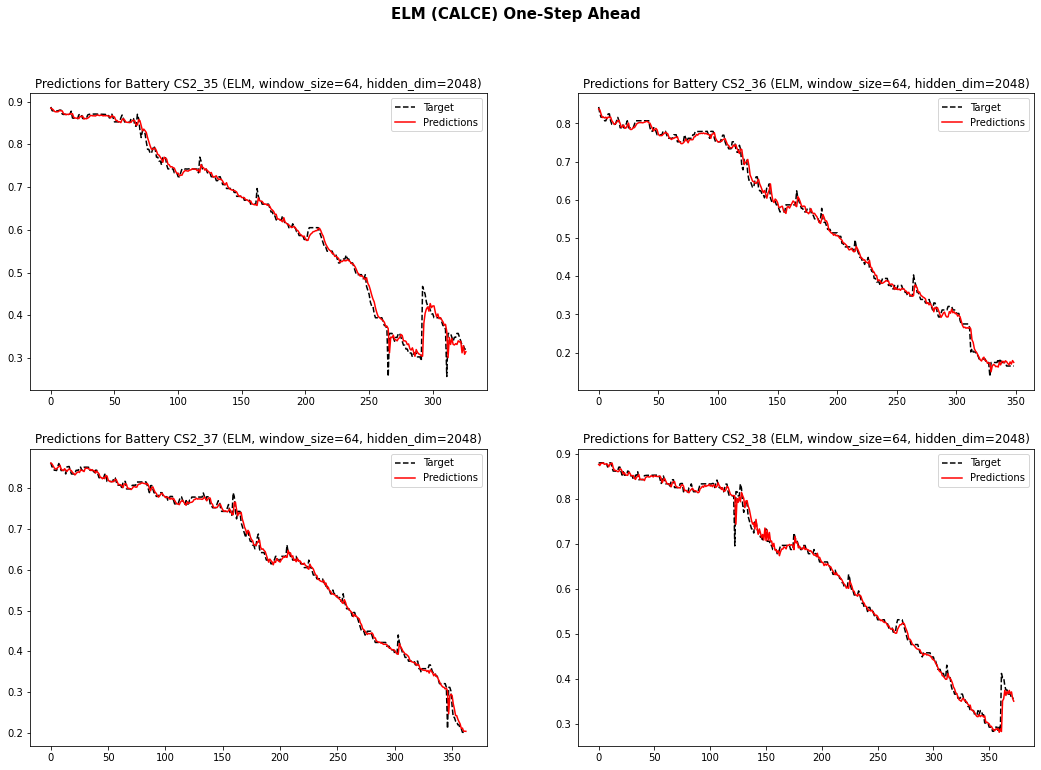

In [ ]:
plt.figure(figsize=(18,12))
plt.suptitle('ELM (CALCE) One-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  model[leave_out].eval()
  pred = []

  with torch.inference_mode():
    for test_tensor, label in zip(X_test[leave_out], y_test[leave_out]):
      preds = model[leave_out](test_tensor)
      pred.append(preds)

  pred = torch.cat(pred)

  # Printing Accuracy, MAE, and RMSE metrics
  acc = accuracy(y_test[leave_out].reshape(-1), pred) * 100
  mae = mean_absolute_error(y_test[leave_out].cpu(),pred.cpu())
  rmse = mean_squared_error(y_test[leave_out].cpu(),pred.cpu())
  print(f"Performance on Test Data {leave_out}\nAccuracy: {acc:.5f}%\tMAE: {mae:.5f}\tRMSE: {rmse:.5f}")

  # RUL Error
  idx_test = (y_test[leave_out].reshape(-1) < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_test = idx_test[0][0]
  if(y_test[leave_out][int(rul_test)+1] > Rated_Capacity*threshold):
    rul_test = idx_test[0][1]
  idx_pred = (pred < Rated_Capacity*threshold).nonzero(as_tuple=True)
  rul_pred = idx_pred[0][0]
  print(f"RUL True: {rul_test}\t\tRUL Pred: {rul_pred}\tRUL Error: {rul_test - rul_pred}\n{'-'*64}")

  # Plotting
  plt.subplot(2,2,idx+1)
  plt.plot(y_test[leave_out].cpu(),'k--',label="Target")
  plt.plot(pred.cpu(),'r-',label="Predictions")
  plt.title(f"Predictions for Battery {leave_out} (ELM, window_size={window_size}, hidden_dim={hidden_dim})")
  plt.legend()

### Iterative Multi-Step Ahead Prediction
Test using iterative prediction (using predicted output to predict future points)

In [ ]:
def plot_predictions(train_cap, train_cyc, label_cap, label_cyc, predictions, title):
  plt.title(title)
  plt.plot(train_cyc, train_cap, 'k-', label='Input data')
  plt.plot(label_cyc, label_cap, 'k:', label='Target')
  plt.plot(label_cyc, predictions, 'b-', label='Predicted')
  plt.legend()
  plt.xlabel('Number of Discharge Cycles')
  plt.ylabel('Capacity (in Ah)')

Performance for Test Data CS2_35:
Accuracy: 93.150064%	MAE: 0.0316	RMSE: 0.0470
RUL True: 111		RUL Pred: 126	RUL Error: 15
----------------------------------------------------------------
Performance for Test Data CS2_36:
Accuracy: 86.286943%	MAE: 0.0641	RMSE: 0.0719
RUL True: 83		RUL Pred: 52	RUL Error: -31
----------------------------------------------------------------
Performance for Test Data CS2_37:
Accuracy: 91.276267%	MAE: 0.0455	RMSE: 0.0550
RUL True: 133		RUL Pred: 117	RUL Error: -16
----------------------------------------------------------------
Performance for Test Data CS2_38:
Accuracy: 87.086151%	MAE: 0.0665	RMSE: 0.0775
RUL True: 147		RUL Pred: 116	RUL Error: -31
----------------------------------------------------------------


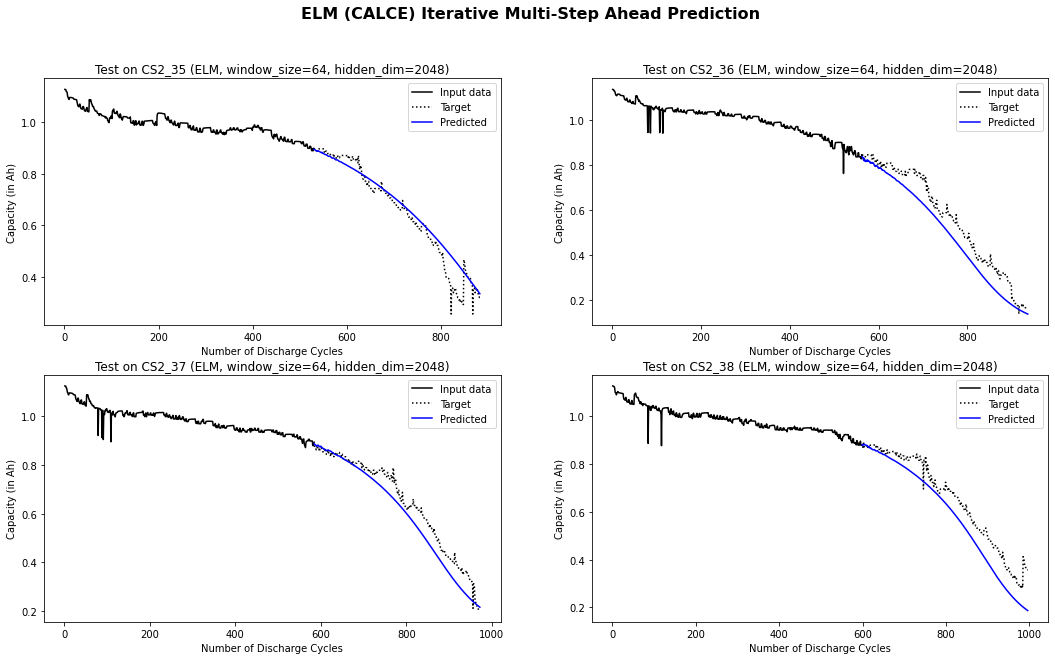

In [ ]:
plt.figure(figsize=(18,10))
plt.suptitle(f'ELM (CALCE) Iterative Multi-Step Ahead Prediction', fontsize=16, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):

  predictions = {}

  for item, i in zip([leave_out], range(len(leave_out))):
    # access dictionary contents
    eval_cap, eval_cyc = test_sequence[leave_out][item]
    test_cap, test_cyc = test_labels[leave_out][item]

    # convert lists to tensors
    eval_cap, eval_cyc = eval_cap, eval_cyc
    test_cap, test_cyc = np.array(test_cap), np.array(test_cyc)

    # create point list which contains predictions
    preds = []
    # sequence which contains prediction inputs (last window_size entries of array)
    seq = eval_cap[-window_size:].tolist()

    for j in range(len(test_cap)):
      pred = model[leave_out](torch.tensor(seq, dtype=torch.float32, device=device))
      seq = seq[1:]
      seq.append(np.float64(pred))
      preds.append(np.float64(pred))

    # copy preds to dictionary
    preds = np.array(preds)
    predictions[item] = preds

    plt.subplot(2, 2, idx+1)
    plot_predictions(train_cap = eval_cap,
                    train_cyc = eval_cyc,
                    label_cap = test_cap,
                    label_cyc = test_cyc,
                    predictions = preds,
                    title = f"Test on {leave_out} (ELM, window_size={window_size}, hidden_dim={hidden_dim})")
    
    # Print accuracy, MAE, RMSE
    error = np.abs(preds - test_cap)/test_cap
    acc = np.ones_like(error)- error
    acc = np.sum(acc)/len(test_cap) * 100
    mae = mean_absolute_error(test_cap,preds)
    rmse = sqrt(mean_squared_error(test_cap,preds))
    print(f"Performance for Test Data {item}:\nAccuracy: {acc:5f}%\tMAE: {mae:.4f}\tRMSE: {rmse:.4f}")


    # RUL Error
    idx_test = (torch.tensor(test_cap) < Rated_Capacity*threshold).nonzero(as_tuple=True)
    rul_test = idx_test[0][0]
    #if(test_cap[int(rul_test)+1] > Rated_Capacity*threshold):
    #  rul_test = idx_test[0][1]
    idx_pred = (torch.tensor(preds) < Rated_Capacity*threshold).nonzero(as_tuple=True)
    rul_pred = idx_pred[0][0]
    print(f"RUL True: {rul_test}\t\tRUL Pred: {rul_pred}\tRUL Error: {rul_pred - rul_test}\n{'-'*64}")